In [30]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import os

In [31]:
data = {}
for i in range(1, 8):
    with open(f'/Users/arushramteke/Desktop/Wenchuan/boxes/output/box_{i}.pkl', 'rb') as f:
        data[f'box_{i}'] = pickle.load(f)
    # data[f'box_{i}']['X']['lithology'] = data[f'box_{i}']['X']['lithology'].astype(int)
    # with open(f'/Users/arushramteke/Desktop/Wenchuan/boxes/output/box_{i}.pkl', 'wb') as f:
    #     pickle.dump(data, f)

In [32]:
for col in data['box_1']['X']:
    if data['box_1']['X'][col].dtype != 'float32':
        print(col)

lithology


In [34]:
cols = data['box_1']['X'].columns
for col in cols:
    if 'inventory' in col or 'slopeuints' in col:
        print(col)

In [29]:
print(np.any(pd.isna(data['box_1']['X']).to_numpy()))

False


In [ ]:
data['box_1']['X']['lithology'] = data['box_1']['X']['lithology'].astype(int)
pd.get_dummies(data['box_1']['X'], columns=['lithology'], drop_first=False)

Index(['MAP_mean', 'MAP_var', 'relief_mean', 'relief_var', 'curv_profile_mean',
       'curv_profile_var', 'curv_profile_min', 'curv_profile_max',
       'elevation_mean', 'elevation_var', 'clay_mean', 'clay_var',
       'aspect_map_mean', 'aspect_map_var', 'inventory_mean', 'inventory_var',
       'slopeunits_mean', 'slopeunits_var', 'curv_planform_mean',
       'curv_planform_var', 'PGA_mean', 'PGA_var', 'region_mean', 'region_var',
       'sm_day_before_mean', 'sm_day_before_var', 'curv_total_mean',
       'curv_total_var', 'curv_total_min', 'curv_total_max', 'silt_mean',
       'silt_var', 'slope_mean', 'slope_var', 'slope_min', 'slope_max',
       'distance_to_channel_mean', 'distance_to_channel_var', 'sand_mean',
       'sand_var', 'distance_to_active_fault_mean',
       'distance_to_active_fault_var', 'curv_mean_mean', 'curv_mean_var',
       'curv_mean_min', 'curv_mean_max', 'NEE_mean', 'NEE_var',
       'discharge_mean', 'discharge_var', 'lithology_1', 'lithology_3',
       'l

In [5]:
y = np.concatenate([data[f'box_{i}']['y'] for i in range(1, 8)])

<Axes: ylabel='Density'>

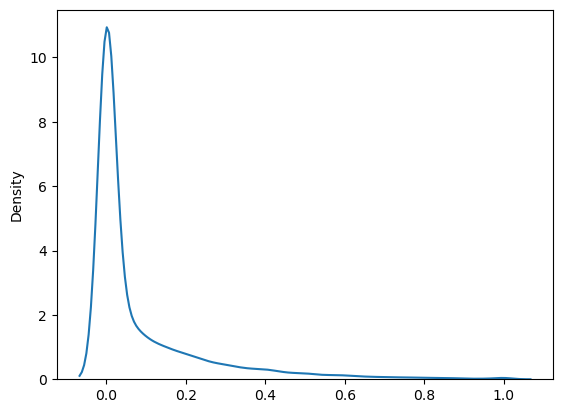

In [6]:
import seaborn as sns
sns.kdeplot(y)

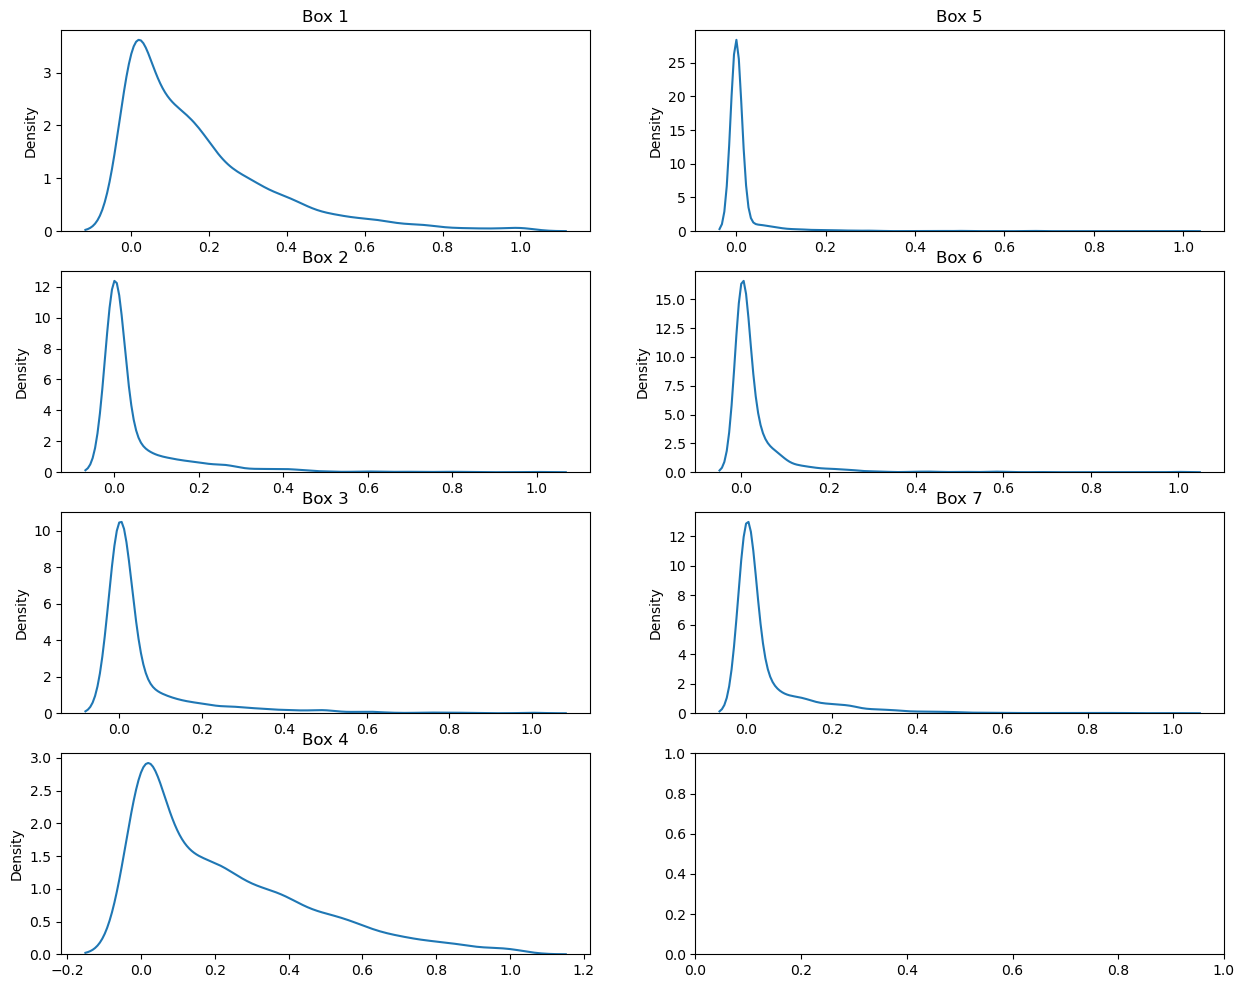

In [18]:
fig, ax = plt.subplots(4, 2, figsize=(15, 12))
for i in range(7):
    y_vec = data[f'box_{i+1}']['y']
    r, c = i % 4, i // 4
    sns.kdeplot(y_vec, ax=ax[r][c])
    ax[r][c].set_title(f'Box {i+1}')


In [7]:
import pickle
import rasterio
import numpy as np
import pandas as pd

data = {}
for i in range(1, 8):
    with open(f'../wenchuan/processed_data/box_{i}.pkl', 'rb') as f:
        data[f'box_{i}'] = pickle.load(f)

In [11]:
counts = [len(data[key]['X']) for key in data]
num_landslides = [np.mean(data[key]['y']) for key in data]
names = [key for key in data]

In [14]:
pd.DataFrame({'Region': names, 'Number of SUs': counts, 'Mean Landslide Coverage': num_landslides})

,Region,Number of SUs,Mean Landslide Coverage
0,box_1,2971,0.173895
1,box_2,3048,0.052195
2,box_3,2359,0.057619
3,box_4,2214,0.222901
4,box_5,2617,0.014104
5,box_6,1782,0.030834
6,box_7,3245,0.049984


#### Box Generation

In [1]:
import geopandas as gpd
from shapely.geometry import Polygon
import numpy as np

def generate_grid(bounds, cell_size):
    """
    Generate a list of square polygons (fishnet) covering the bounding box.

    Parameters
    ----------
    bounds : tuple (minx, miny, maxx, maxy)
        Bounding box of the geometry.
    cell_size : float
        The desired size of each grid cell (square).

    Returns
    -------
    List of shapely.geometry.Polygon
        List of square polygons.
    """
    minx, miny, maxx, maxy = bounds
    
    # Generate the x and y coordinates of the grid cells
    x_coords = np.arange(minx, maxx, cell_size)
    y_coords = np.arange(miny, maxy, cell_size)
    
    # Create polygons for each cell in the grid
    polygons = []
    for x in x_coords:
        for y in y_coords:
            # Coordinates of the square cell
            x2 = x + cell_size
            y2 = y + cell_size
            
            # Create the polygon
            square = Polygon([
                (x, y),
                (x2, y),
                (x2, y2),
                (x, y2)
            ])
            polygons.append(square)
    
    return polygons

def split_into_grid(original_poly, cell_size):
    """
    Split a single polygon (original_poly) into smaller squares of size cell_size,
    preserving the original boundary where intersections occur.
    
    Parameters
    ----------
    original_poly : shapely.geometry.Polygon or MultiPolygon
    cell_size : float
    
    Returns
    -------
    geopandas.GeoDataFrame
        GeoDataFrame containing the intersected squares.
    """
    # 1. Get the bounding box of the polygon
    bounds = original_poly.bounds
    
    # 2. Generate the grid (fishnet) of squares
    squares = generate_grid(bounds, cell_size)
    
    # 3. Intersect each grid square with the original polygon
    intersected_squares = []
    for sq in squares:
        intersected = sq.intersection(original_poly)
        if not intersected.is_empty:
            intersected_squares.append(intersected)
    
    # 4. Convert to GeoDataFrame
    gdf = gpd.GeoDataFrame(geometry=intersected_squares, crs="EPSG:4326")
    return gdf

In [2]:
# Load the polygon shapefile
# Replace 'your_shapefile.shp' with your actual shapefile path
gdf_poly = gpd.read_file('~/Desktop/Wenchuan/polygons/region_bound.shp')

In [3]:
# If the shapefile has multiple polygons, you might iterate over each row.
# For demonstration, assume there is only one (or that we dissolve them).
original_poly = gdf_poly.union_all()  # This merges all polygons into one

# Desired cell size (in the same units as your shapefile)
cell_size = 1000  # for example, 1,000 units on each side

# Split into grid
result_gdf = split_into_grid(original_poly, cell_size)

# Optionally save to a new shapefile
result_gdf.to_file('~/Desktop/Wenchuan/polygons/split_grid_region_bound.shp')

/var/folders/wg/rc950kx52952n0613q25df340000gn/T/ipykernel_93069/4254012442.py:3: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  original_poly = gdf_poly.unary_union  # This merges all polygons into one


In [14]:
import numpy as np
import rasterio

def compute_slopeunit_centroids(raster_path):
    """
    Reads a slope-units raster from 'raster_path', where each slope unit
    is identified by a unique integer ID. Computes the centroid
    (x, y) in map coordinates for each ID.
    
    Returns
    -------
    centroids : dict
        Dictionary keyed by slope-unit ID, with values = (x, y) centroid.
    """
    with rasterio.open(raster_path) as src:
        slope_units = src.read(1)  # read the first (and only) band
        transform = src.transform
        # If needed, check src.crs for the coordinate system

    # Identify unique nonzero IDs (assuming 0 or nodata means "no slope unit")
    unique_ids = np.unique(slope_units)
    unique_ids = unique_ids[unique_ids != 0]  # filter out 0 if present

    centroids = np.zeros((len(unique_ids), 2), dtype=np.float64)
    for uid in unique_ids:
        # Get all pixels belonging to this slope unit
        rows, cols = np.where(slope_units == uid)
        if len(rows) == 0:
            continue  # skip if empty for some reason
        
        # Compute the mean row and column
        mean_row = rows.mean()
        mean_col = cols.mean()
        
        # Convert (row,col) → (x,y) using the geotransform
        # You can do this manually or use rasterio's transform machinery:
        # x, y = transform * (col, row)
        x, y = rasterio.transform.xy(transform, mean_row, mean_col, offset='center')
        
        centroids[uid-1] = (x, y)
    
    return centroids

In [11]:
raster_path = '/Users/arushramteke/Desktop/Wenchuan/processed_regions/box_1/slopeunits.tif'

In [12]:
with rasterio.open(raster_path) as src:
    slope_units = src.read(1)  # read the first (and only) band
    transform = src.transform
    # If needed, check src.crs for the coordinate system

In [15]:
centroids = compute_slopeunit_centroids(raster_path)

In [17]:
with open('/Users/arushramteke/Desktop/Wenchuan/pipeline_dump/box_1.pkl', 'rb') as f:
    d = pickle.load(f)

In [19]:
d['features'].shape

(17, 910, 752)

In [20]:
d['centroids'].shape

(4865, 2)